In [93]:
import numpy as np
import os
import tarfile
import pandas as pd
from sklearn.datasets import california_housing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,adjusted_rand_score
%matplotlib inline

In [42]:
# download data and store to a data frame
data = california_housing.fetch_california_housing()
df = pd.DataFrame(data= data.data, columns=data.feature_names)    
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [43]:
# Note that we're missing the prices column
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [44]:
# Fetch prices from the dataset
p=data.target
p

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [45]:
#converting prices to it's own dataframe for use later on in the split
p_df=pd.DataFrame({"prices":p})
p_df.head()

,prices
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [47]:
#concatenating both dataframes to get the complete dataset
calf_hous_df = pd.concat([df,p_df],axis=1)

In [49]:
# Complete dataset
calf_hous_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,prices
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [50]:
# check for nulls
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

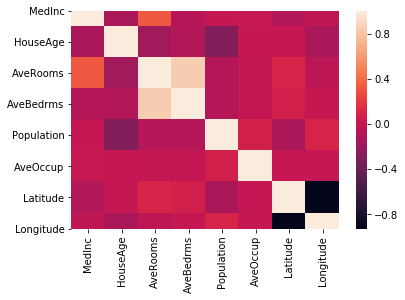

In [52]:
# Correlation heatmap
sns.heatmap(df.corr())

## Linear Regression Baseline Model

##### Here, we take the baseline housing data and run it through a linear regression model in an attempt to predict price. This is a very simplistic model of course, but it gives us a starting point and something to compare to as we move further along in the project.

##### We split the data using an 80/20 split. We can see that this produces a training data set of 16,512 rows x 8 columns. The corresponding predictor training set is also 16,512 rows x 1 column (prices).

In [81]:
# Split training and test data set using an 80/20 split
calf_hous_df_2 = calf_hous_df[calf_hous_df.columns[~calf_hous_df.columns.isin(['prices'])]]

x_train,x_test,y_train,y_test=train_test_split(calf_hous_df_2,p_df,test_size=0.2,random_state=7)

In [82]:
x_train.shape

(16512, 8)

In [83]:
x_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
17142,4.4688,43.0,5.353247,1.135065,817.0,2.122078,37.45,-122.18
5460,2.6042,37.0,3.508820,1.037992,1801.0,2.443691,34.00,-118.47
7920,3.4250,28.0,5.421212,1.066667,1347.0,4.081818,33.86,-118.07
15846,5.0519,40.0,5.094538,1.026261,1824.0,1.915966,37.75,-122.43
18194,3.2574,32.0,3.718504,0.958661,1321.0,2.600394,37.38,-122.02


In [84]:
y_train.shape

(16512, 1)

In [85]:
y_train.head()

,prices
17142,4.602
5460,3.058
7920,1.897
15846,3.561
18194,2.544


In [88]:
# train the linear regression model
baseline_model = LinearRegression()
baseline_model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
# predict using the test data
baseline_model_pred = ca_baseline_model.predict(x_test)

In [92]:
# predicted values for price
baseline_model_pred

array([[1.65084222],
       [2.47797721],
       [2.42550694],
       ...,
       [1.86032202],
       [2.39125575],
       [3.84598092]])

In [94]:
# How accuratge is our baseline model? Let's return the R2 score
r2_baseline = r2_score(baseline_model_pred,y_test)
r2_baseline

# 0.334 is a pretty poor score for a baseline model. Can we do better?

0.33402076446561